In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_dir = "/content/drive/MyDrive/WIDER_train.zip (Unzipped Files)/WIDER_train"
test_dir = "/content/drive/MyDrive/WIDER_test.zip (Unzipped Files)/WIDER_test"
validation_dir = "/content/drive/MyDrive/WIDER_val.zip (Unzipped Files)/WIDER_val"

In [ ]:
import pandas as pd
import numpy as np
import os
from random import shuffle,choice,choices
import cv2
import matplotlib.pyplot as plt
from random import shuffle,choice,choices
import numpy as np
from tensorflow.keras.utils import Sequence
import tensorflow as tf
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from random import shuffle,choice,choices
from tensorflow.keras.layers import *
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau,LearningRateScheduler
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
import tensorflow as tf
from tensorflow.keras.layers import UpSampling2D,Conv2D
from keras.optimizers import Adam

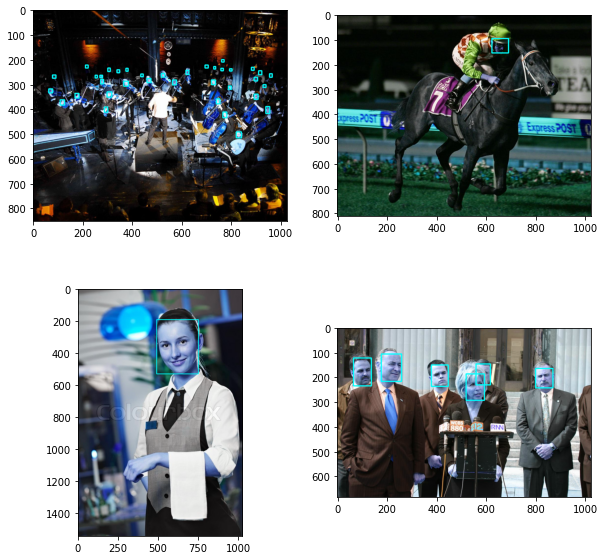

In [ ]:
filename = '/content/drive/MyDrive/wider_face_split.zip (Unzipped Files)/wider_face_split/wider_face_train_bbx_gt.txt'
X = []
q = []
file = open(filename,mode = 'r')
for x in file:
  #print(x,end = '\r')
  #x = file.readline()
  if(x[2:3] == '-'):
    x = x.rstrip('\n')
    X.append(x)
    x = next(file)
    m = int(x)
    L = []
    for i in range(0,m):
      x = next(file)
      x = x[0:]
      x = x.split()
      Y = []
      for i in range(0,4):
       Y.append(int(float(x[i])))
      L.append(Y)
    q.append(L)

k = 4//2
fig,ax = plt.subplots(k,2,figsize = (10,10))
idxes = choices([i for i in range(len(X))],k=k*2)
for i,idx in enumerate(idxes):
  img = cv2.imread(train_dir+'/'+'images'+'/'+X[idx])
  bboxes = q[idx]
  for bbox in bboxes:
    xmin = bbox[0]
    ymin = bbox[1]
    xmax = bbox[0]+bbox[2]
    ymax = bbox[1]+bbox[3]
    cv2.rectangle(img,(xmin,ymin),(xmax,ymax),(0,255,255),4)
  ax[int(i//2)][int(i%2)].imshow(img)
 



In [ ]:
L = []
class Mygenerator(Sequence):
  def __init__(self,X,q,train_dir = train_dir,stride = 4,input_size = 512,is_train = False,batch_size = 2):
    self.X = X
    self.q = q
    self.train_dir = train_dir
    self.stride = stride
    self.input_size = input_size
    self.is_train = is_train
    self.output_size = self.input_size//self.stride
    self.batch_size = batch_size
    '''if self.is_train:
      self.on_epoch_end()'''

  def __len__(self):
    return int(np.ceil(len(self.X)/float(self.batch_size)))
  '''def on_epoch_end(self):
    if(self.is_train):
      temp = list(zip(self.X,self,q))
      shuffle(temp)
      self.X,self.q = zip(*temp)'''
  def __getitem__(self,idx):
    batch_x = self.X[idx:(idx+3)]
    batch_q = self.q[idx:(idx+3)]
    if self.is_train:
      return self.train_generator(batch_x,batch_q)
    else:
      return self.valid_generator(batch_x,batch_q)
  def train_generator(self,batch_x,batch_q):
    H = []
    heatmaps = []
    J = []
    output_height = 128
    output_width = 128
    for idx,image_name in enumerate(batch_x):
      image_dir = os.path.join(self.train_dir,'images',image_name)
      img  = cv2.imread(image_dir)
      img_height,img_width,c = img.shape[0],img.shape[1],img.shape[2]
      img = cv2.resize(img,(self.input_size,self.input_size))
      output = np.zeros((128,128,6))
      bboxes = batch_q[idx]
      for bbox in bboxes :
        xc = bbox[0] + (bbox[2]/2)
        yc = bbox[1] + (bbox[3]/2)
        width = bbox[2]
        height = bbox[3]
        xc,yc,width,height = xc*(128)/(img_width),yc*(128)/(img_height),width*(128)/(img_width),height*(128)/(img_height)
        heatmap=((np.exp(-(((np.arange(128)-xc)/(width/10))**2)/2)).reshape(1,-1)*(np.exp(-(((np.arange(128)-yc)/(height/10))**2)/2)).reshape(-1,1))
        R = np.argwhere(heatmap[:,:] >= 1)
        output[:,:,0] = np.maximum(output[:,:,0],heatmap[:,:])
        output[int(yc//1),int(xc//1),1] = 1
        output[int(yc//1),int(xc//1),2] = yc%1
        output[int(yc//1),int(xc//1),3] = xc%1
        output[int(yc//1),int(xc//1),4] = width/output_width
        output[int(yc//1),int(xc//1),5] = height/output_height
      H.append(img)
      J.append(output)  
    H = np.asarray(H)
    J = np.asarray(J)
    #print(J.shape)
    return H/255.0,J
  def valid_generator(self,batch_x,batch_q):
    H = []
    heatmaps = []
    J = []
    output_height = 128
    output_width = 128
    for idx,image_name in enumerate(batch_x):
      image_dir = os.path.join(self.train_dir,'images',image_name)
      img  = cv2.imread(image_dir)
      #print(print_h)
      #print(print_w)
      img_height,img_width,c = img.shape[0],img.shape[1],img.shape[2]
      #print(img_height)
      img = cv2.resize(img,(self.input_size,self.input_size))
      #print(img.shape)
      output = np.zeros((output_height,output_width,6))
      bboxes = batch_q[idx]
      #print(len(bboxes))
      for bbox in bboxes :
        xc = bbox[0] + (bbox[2]/2)
        #print(xc)
        yc = bbox[1] + (bbox[3]/2)
        width = bbox[2]
        height = bbox[3]
        xc,yc,width,height = xc*(128)/(img_width),yc*(128)/(img_height),width*(128)/(img_width),height*(128)/(img_height)
        heatmap=((np.exp(-(((np.arange(128)-xc)/(width/10))**2)/2)).reshape(1,-1)*(np.exp(-(((np.arange(128)-yc)/(height/10))**2)/2)).reshape(-1,1))
        print(heatmap.shape)
        #print(heatmap)
        output[:,:,0] = np.maximum(output[:,:,0],heatmap[:,:])
        #print(x)
        output[int(yc//1),int(xc//1),1] = 1
        output[int(yc//1),int(xc//1),2] = yc%1
        output[int(yc//1),int(xc//1),3] = xc%1
        output[int(yc//1),int(xc//1),4] = width/128
        output[int(yc//1),int(xc//1),5] = height/128
      H.append(img)
      J.append(output)  
    H = np.asarray(H)
    J = np.asarray(J)
    #print(J.shape)
    return H/255.0,J

In [ ]:
'''vgg = VGG19(
    input_shape = (512,512,3),
    include_top=False,
    weights='imagenet'
)
for layers in vgg.layers:
  layers.trainable = False
last_layer = vgg.get_layer("block5_conv4")
last_output = last_layer.output
x = UpSampling2D((2,2))(last_output)
x = Conv2D(128,(2,2),activation = 'relu',kernel_initializer='glorot_uniform',padding='same')(x)
x = UpSampling2D((2,2))(x)
x = Conv2D(5,(2,2),activation = 'sigmoid',kernel_initializer='glorot_uniform',padding='same')(x)
prediction_model = Model(vgg.input,x)
zeros = tf.expand_dims(tf.zeros_like(x[...,0]),axis=-1)
x = tf.concat([zeros,x],axis = -1)
model = Model(vgg.input,x)
prediction_model.summary()
model.compile(loss = loss_fn(1.5,2.5),optimizer = 'adam',metrics = [off_loss,size_metric(),cls_metric(1.5,2.5)])'''

'vgg = VGG19(\n    input_shape = (512,512,3),\n    include_top=False,\n    weights=\'imagenet\'\n)\nfor layers in vgg.layers:\n  layers.trainable = False\nlast_layer = vgg.get_layer("block5_conv4")\nlast_output = last_layer.output\nx = UpSampling2D((2,2))(last_output)\nx = Conv2D(128,(2,2),activation = \'relu\',kernel_initializer=\'glorot_uniform\',padding=\'same\')(x)\nx = UpSampling2D((2,2))(x)\nx = Conv2D(5,(2,2),activation = \'sigmoid\',kernel_initializer=\'glorot_uniform\',padding=\'same\')(x)\nprediction_model = Model(vgg.input,x)\nzeros = tf.expand_dims(tf.zeros_like(x[...,0]),axis=-1)\nx = tf.concat([zeros,x],axis = -1)\nmodel = Model(vgg.input,x)\nprediction_model.summary()\nmodel.compile(loss = loss_fn(1.5,2.5),optimizer = \'adam\',metrics = [off_loss,size_metric(),cls_metric(1.5,2.5)])'

In [ ]:
vgg = VGG19(
    input_shape = (512,512,3),
    include_top=False,
    weights='imagenet'
)
for layers in vgg.layers:
  layers.trainable = False
last_layer = vgg.get_layer("block5_conv4")
last_output = last_layer.output
x = UpSampling2D((2,2))(last_output)
x = Conv2D(128,(2,2),activation = 'relu',kernel_initializer='glorot_uniform',padding='same')(x)
x = Dropout(0.25)(x)
x = Conv2D(64,(2,2),activation = 'relu',kernel_initializer='glorot_uniform',padding='same')(x)
x = Conv2D(32,(2,2),activation = 'relu',kernel_initializer='glorot_uniform',padding='same')(x)
x = UpSampling2D((2,2))(x)
x = Conv2D(64,(2,2),activation = 'relu',kernel_initializer='glorot_uniform',padding='same')(x)
x = Dropout(0.25)(x)
x = Conv2D(32,(2,2),activation = 'relu',kernel_initializer='glorot_uniform',padding='same')(x)
x = Conv2D(5,(2,2),activation = 'sigmoid',kernel_initializer='glorot_uniform',padding='same')(x)
prediction_model = Model(vgg.input,x)
zeros = tf.expand_dims(tf.zeros_like(x[...,0]),axis=-1)
x = tf.concat([zeros,x],axis = -1)
model = Model(vgg.input,x)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 512, 512, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 512, 512, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 256, 256, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

In [ ]:

def focal_loss(gamma,gamma2,y_true,y_pred,heatmaps):
    '''focal loss'''
    y_pred = K.clip(y_pred,1e-5,1-1e-5)
    loglik = 2*y_true*((1-y_pred)**gamma)*K.log(y_pred) +(1-y_true)*((1-heatmaps)**gamma2)*(y_pred**gamma)*K.log(1-y_pred)
    #heatloss=-K.sum(heatmap_true*((1-heatmap_pred)**alpha)*K.log(heatmap_pred+1e-6)+(1-heatmap_true)*((1-heatmap_true_rate)**beta)*(heatmap_pred**alpha)*K.log(1-heatmap_pred+1e-6))

    cls_loss = -K.sum(loglik,axis=0)
    return cls_loss

def loss_fn(gamma1,gamma2):
    '''final combined loss and supporting functions'''
    def final_loss(y_true,y_pred):
        mask = K.batch_flatten(K.sign(y_true[...,4]*128))
        N = K.sum(mask)
        heatmaps = K.batch_flatten(y_true[...,0])
        cls_pred = K.batch_flatten(y_pred[...,1])
        cls_pred = K.clip(cls_pred,1e-7,1-1e-7)
        cls_true = K.batch_flatten(y_true[...,1])

        cls_loss = K.sum(focal_loss(gamma1,gamma2,cls_true,cls_pred,heatmaps))/N
    
        offy_pred = K.batch_flatten(y_pred[...,2])
        offx_pred = K.batch_flatten(y_pred[...,3])
        offy_true = K.batch_flatten(y_true[...,2])
        offx_true = K.batch_flatten(y_true[...,3])
        offloss = K.abs(offx_pred*mask-offx_true) + K.abs(offy_pred*mask-offy_true)
        offloss = K.sum(offloss)/N
    
        sizey_true = K.batch_flatten(y_true[...,4])
        sizey_pred = K.batch_flatten(y_pred[...,4])
        sizex_true = K.batch_flatten(y_true[...,5])
        sizex_pred = K.batch_flatten(y_pred[...,5])
        y_mask = tf.cast(sizey_pred>0.4,dtype=tf.float32)
        x_mask = tf.cast(sizex_pred>0.4,dtype=tf.float32)
        y_weight = y_mask*sizey_pred
        x_weight = x_mask*sizex_pred
        size_loss = K.sum(K.abs(sizex_pred*mask-sizex_true)*(1+x_weight)+K.abs(sizey_pred*mask-sizey_true)*(1+y_weight))/N 
        loss = (1*cls_loss+1*offloss+0.1*size_loss)
        return loss
    return final_loss

In [ ]:
def cls_metric(gamma1,gamma2):
    def closs(y_true,y_pred):
        mask = K.batch_flatten(K.sign(y_true[...,4]*128))
        N = K.sum(mask)
        heatmaps = K.batch_flatten(y_true[...,0])
        cls_pred = K.batch_flatten(y_pred[...,1])
        cls_pred = K.clip(cls_pred,1e-7,1-1e-7)
        cls_true = K.batch_flatten(y_true[...,1])
        cls_loss = K.sum(focal_loss(gamma1,gamma2,cls_true,cls_pred,heatmaps))/N
        return cls_loss
    return closs
    
def off_loss(y_true,y_pred):
    mask = K.batch_flatten(K.sign(y_true[...,4]*128))
    N = K.sum(mask)
    offy_pred = K.batch_flatten(y_pred[...,2])
    offx_pred = K.batch_flatten(y_pred[...,3])
    offy_true = K.batch_flatten(y_true[...,2])
    offx_true = K.batch_flatten(y_true[...,3])
    offloss = K.abs(offx_pred*mask-offx_true) + K.abs(offy_pred*mask-offy_true)
    offloss = K.sum(offloss)/N
    return offloss
def size_metric():
    def sloss(y_true,y_pred):
        mask = K.batch_flatten(K.sign(y_true[...,4]*128))
        N = K.sum(mask)
        sizey_true = K.batch_flatten(y_true[...,4])
        sizey_pred = K.batch_flatten(y_pred[...,4])
        sizex_true = K.batch_flatten(y_true[...,5])
        sizex_pred = K.batch_flatten(y_pred[...,5])
        y_mask = tf.cast(sizey_pred>0.4,dtype=tf.float32)
        x_mask = tf.cast(sizex_pred>0.4,dtype=tf.float32)
        y_weight = y_mask*sizey_pred
        x_weight = x_mask*sizex_pred
        size_loss = K.sum(K.abs(sizex_pred*mask-sizex_true)*(1+x_weight)+K.abs(sizey_pred*mask-sizey_true)*(1+y_weight))/N#size_loss2 = K.sum(K.abs(sizex_pred*mask-sizex_true)*(1-sizex_true)*mask+K.abs(sizey_pred*mask-sizey_true)*(1-sizey_true)*mask,axis=-1)
        #size_loss = 0.8*size_loss1+0.2*size_loss2
        return size_loss
    return sloss

In [ ]:
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)
checkpoint_path = '/content/drive/MyDrive/Untitled Folder 6/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint = ModelCheckpoint(checkpoint_path,monitor = 'val_loss', save_weights_only = True, verbose = 1, period = 1)

In [ ]:
valid = X[:100]
print(len(valid))
valid_q = q[:100]
print(len(valid_q))
train = X[100:8100]
print(len(train))
train_q = q[100:8100]
print(len(train_q))
train_gen = Mygenerator(train,train_q,batch_size = 2,is_train = True)
valid_gen = Mygenerator(valid,valid_q,batch_size = 2,is_train = False)
def lrs(epoch):
    lr = 0.001
    if epoch >= 20: lr = 0.0002
    return lr

lr_schedule = LearningRateScheduler(lrs)
callbacks = [earlystop, learning_rate_reduction,checkpoint]

In [ ]:
history = model.fit_generator(train_gen,epochs = 20 ,verbose = 1,validation_data = valid_gen,callbacks = callbacks)



In [ ]:
from __future__ import print_function
dir = f'{test_dir}/images/1--Handshaking'
files = os.listdir(dir)
dir
imagename = []
for name in files:
  imagename.append(name)
H =[]
H.append(imagename[9])
H.append(imagename[10])
H.append(imagename[11])
H.append(imagename[12])
H.append(imagename[13])
H.append(imagename[14])
H.append(imagename[15])
H
category_n = 1
pred_out_h = 128
pred_out_w = 128


In [ ]:
def _ctdet_decode(hm, reg, wh, k=20, output_stride=2):
    bboxes = []
    scores = []
    hm = K.eval(_nms(tf.cast(hm,tf.float32)))
    hm = hm[0,:,:,0]
    w = hm.shape[0]
    hm_ = np.zeros_like(hm)
    hm_flat = hm.reshape(-1)
    for i in range(k):
        m = np.argmax(hm_flat)
        hm_[m//w][m%w] = hm_flat[m]
        hm_flat[m] = -1
    points = np.argwhere(hm_[:,:]!=0)
    
    #print(points.shape)
    for (y,x) in points:
        #print(type(y),type(x))
        score = hm_[y,x]
        offy = reg[0,y,x,0]
        offx = reg[0,y,x,1]
        height = wh[0,y,x,0]*OUTPUT_SIZE
        width = wh[0,y,x,1]*OUTPUT_SIZE
        xc = x+offx
        yc = y+offy
        xmin = int((xc-(width/2)))
        ymin = int((yc-(height/2)))
        xmax = int((xc+(width/2)))
        ymax = int((yc+(height/2)))
        bboxes.append([xmin,ymin,xmax,ymax])
        scores.append(score)
    return scores,bboxes
def _nms(heat, kernel=10):
    hmax = K.pool2d(heat, (kernel, kernel), padding='same', pool_mode='max')
    #hmax2 = K.pool2d(heat, (kernel[1], kernel[1]), padding='same', pool_mode='max')
    #hmax3 = K.pool2d(heat, (kernel[2], kernel[2]), padding='same', pool_mode='max')
    #hmax = (hmax1+hmax2+hmax3)/3
    keep = K.cast(K.equal(hmax, heat), K.floatx())
    return heat * keep
def NMS_all(predicts, pred_out_h, pred_out_w, score_thresh,iou_thresh):
    y_c=predicts[...,1]+np.arange(pred_out_h).reshape(-1,1)
    x_c=predicts[...,2]+np.arange(pred_out_w).reshape(1,-1)
    height=predicts[...,3]*pred_out_h
    width=predicts[...,4]*pred_out_w

    count=0
    for category in range(1):
        predict=predicts[...,category]
        mask=(predict>score_thresh)
        #print(mask)
        #print("box_num",np.sum(mask))
        if mask.all==False:
            continue
        box_and_score=NMS(predict[mask],y_c[mask],x_c[mask],height[mask],width[mask],iou_thresh,pred_out_h, pred_out_w)
        box_and_score=np.insert(box_and_score,0,category,axis=1)#category,score,top,left,bottom,right
        if count==0:
            box_and_score_all=box_and_score
        else:
            box_and_score_all=np.concatenate((box_and_score_all,box_and_score),axis=0)
        count+=1
    score_sort=np.argsort(box_and_score_all[:,1])[::-1]
    box_and_score_all=box_and_score_all[score_sort]
    #print(box_and_score_all)

    _,unique_idx=np.unique(box_and_score_all[:,2],return_index=True)
    #print(unique_idx)
    return box_and_score_all[sorted(unique_idx)]
  
def NMS(score,y_c,x_c,height,width,iou_thresh,pred_out_h, pred_out_w,merge_mode=False):
    if merge_mode:
        score=score
        top=y_c
        left=x_c
        bottom=height
        right=width
    else:
        #flatten
        score=score.reshape(-1)
        y_c=y_c.reshape(-1)
        x_c=x_c.reshape(-1)
        height=height.reshape(-1)
        width=width.reshape(-1)
        size=height*width


        top=y_c-height/2
        left=x_c-width/2
        bottom=y_c+height/2
        right=x_c+width/2

        inside_pic=(top>0)*(left>0)*(bottom<pred_out_h)*(right<pred_out_w)
        outside_pic=len(inside_pic)-np.sum(inside_pic)
        #if outside_pic>0:
        #  print("{} boxes are out of picture".format(outside_pic))
        normal_size=(size<(np.mean(size)*20))*(size>(np.mean(size)/20))
        score=score[inside_pic*normal_size]
        top=top[inside_pic*normal_size]
        left=left[inside_pic*normal_size]
        bottom=bottom[inside_pic*normal_size]
        right=right[inside_pic*normal_size]
  

    

  #sort  
    score_sort=np.argsort(score)[::-1]
    score=score[score_sort]  
    top=top[score_sort]
    left=left[score_sort]
    bottom=bottom[score_sort]
    right=right[score_sort]

    area=((bottom-top)*(right-left))

    boxes=np.concatenate((score.reshape(-1,1),top.reshape(-1,1),left.reshape(-1,1),bottom.reshape(-1,1),right.reshape(-1,1)),axis=1)

    box_idx=np.arange(len(top))
    alive_box=[]
    while len(box_idx)>0:
  
        alive_box.append(box_idx[0])

        y1=np.maximum(top[0],top)
        x1=np.maximum(left[0],left)
        y2=np.minimum(bottom[0],bottom)
        x2=np.minimum(right[0],right)

        cross_h=np.maximum(0,y2-y1)
        cross_w=np.maximum(0,x2-x1)
        still_alive=(((cross_h*cross_w)/area[0])<iou_thresh)
        if np.sum(still_alive)==len(box_idx):
            print("error")
            print(np.max((cross_h*cross_w)),area[0])
        top=top[still_alive]
        left=left[still_alive]
        bottom=bottom[still_alive]
        right=right[still_alive]
        area=area[still_alive]
        box_idx=box_idx[still_alive]
    return boxes[alive_box]#score,top,left,bottom,right

def visualize(box_and_score,img):
    boxes = []
    scores = []
    colors= [(0,0,255), (255,0,0), (0,255,255), (0,127,127), (127,255,127), (255,255,0)]
    classes = ["car", "motor", "person", "bus", "truck", "bike"]
    number_of_rect=np.minimum(500,len(box_and_score))

    for i in reversed(list(range(number_of_rect))):
        predicted_class, score, top, left, bottom, right = box_and_score[i,:]


        top = np.floor(top + 0.5).astype('int32')
        left = np.floor(left + 0.5).astype('int32')
        bottom = np.floor(bottom + 0.5).astype('int32')
        right = np.floor(right + 0.5).astype('int32')

        predicted_class = int(predicted_class)

        label = '{:.2f}'.format(score)
        #print(label)
        #print(top, left, right, bottom)
        cv2.rectangle(img, (left, top), (right, bottom), colors[predicted_class], 3)
        cv2.putText(img, label, (left, top), cv2.FONT_HERSHEY_SIMPLEX ,  
                       0.5, (255,255,255), 2, cv2.LINE_AA) 
        boxes.append([left, top, right-left, bottom-top])
        scores.append(score)
    
    return np.array(boxes), np.array(scores)

In [ ]:
def format_prediction_string(boxes, scores):
  pred_strings = []
  for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))
  return " ".join(pred_strings)

In [ ]:
results = []
fig, axes = plt.subplots(10, 1,figsize=(100,100))
for count, name in enumerate(H):
    ids = name.split('.')[0] 
    imgcv = cv2.imread(dir+'/'+name)
    img = cv2.resize(imgcv, (512, 512))
    #print(img)
    predict0 = np.zeros((128,128,5))
    predict0 = predict0 + prediction_model.predict(img[np.newaxis]/255).reshape(128,128,5)
    print_h, print_w = imgcv.shape[:2]
    #print(predict.shape)

    box_and_score=NMS_all(predict0, pred_out_h, pred_out_w, score_thresh=0.3,iou_thresh=0.5)
    if len(box_and_score)==0:
        print('no boxes found!!')
        #return
        result = {
                'image_id': ids,
                'PredictionString': ''
            }

        results.append(result)
    else:

        #heatmap=predict[:,:,2]

        box_and_score=box_and_score*[1,1,print_h/pred_out_h,print_w/pred_out_w,print_h/pred_out_h,print_w/pred_out_w]
        # img=draw_rectangle(box_and_score[:,2:],img,"red")
        # img=draw_rectangle(true_boxes,img,"blue")
        preds, scores = visualize(box_and_score,imgcv)

        result = {
                'image_id': ids,
                'PredictionString': format_prediction_string(preds, scores)
            }

        results.append(result)
    

    
    # #axes[0].set_axis_off()
    if count <10:
        axes[count].imshow(imgcv)
    # #axes[1].set_axis_off()
    # axes[1].imshow(heatmap)#, cmap='gray')
    # #axes[2].set_axis_off()
    # #axes[2].imshow(heatmap_1)#, cmap='gray')
    #break

In [ ]:
model.load_weights('/content/drive/MyDrive/impt7res/cp.ckpt')
prediction_model.load_weights('/content/drive/MyDrive/impt7res/cp.ckpt')

(128, 128, 5)
(128, 128, 5)
(1, 128, 128, 1)


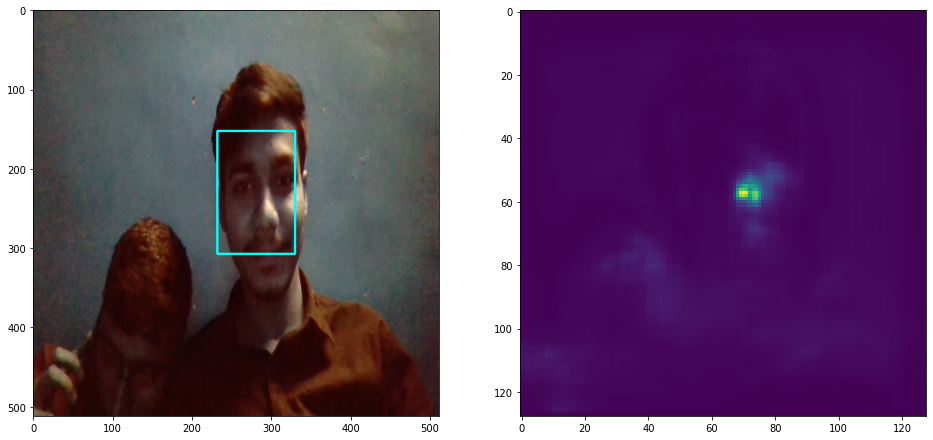

In [ ]:
stride = 4
#img = cv2.imread(dir+'/'+'/pexels-photo-614810.jpeg')
img = cv2.imread('/content/WIN_20210106_19_08_12_Pro.jpg')
imgcv = cv2.resize(img,(512,512),cv2.COLOR_BGR2GRAY)
predict0 = np.zeros((128,128,5))
predict0 = predict0 + prediction_model.predict(imgcv[np.newaxis]/255).reshape(128,128,5)
print(predict0.shape)
Y = np.asarray(predict0)
print(Y.shape)
heatmap = predict0[...,0]
R = heatmap
heat_zeros = np.zeros_like(heatmap)
heatmap = np.expand_dims(heatmap,axis = -1)
heatmap = heatmap.reshape(-1,128,128,1)
print(heatmap.shape)
hmax = K.pool2d(heatmap, (3, 3), padding='same', pool_mode='max')
keep = K.cast(K.equal(hmax, heatmap), K.floatx())
hmax = hmax*keep
heat_1 = hmax[0,:,:,0]
heat_1 = np.asarray(heat_1)
heat_flat = heat_1.reshape(-1)
scores,index = tf.math.top_k(heat_flat,k = 1,sorted = True)
for i in range(len(index)):
  heat_zeros[index[i]//128][index[i]%128] = scores[i]
points = np.argwhere(heat_zeros[:,:] != 0)
for y,x in points:
  offy = Y[y,x,1]
  offx = Y[y,x,2]
  width = Y[y,x,3]*128
  height = Y[y,x,4]*128
  xc = x+offx
  yc = y+offy
  xmin = int((xc-(width/2))*stride)
  ymin = int((yc-(height/2))*stride)
  xmax = int((xc+(width/2))*stride)
  ymax = int((yc+(height/2))*stride)
  cv2.rectangle(imgcv, (xmin, ymin), (xmax, ymax), (0,255,255), 2)
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

ax[0].imshow(imgcv)
ax[1].imshow(R)




In [ ]:
plt.imsave('filename2.png', imgcv)
fig.savefig("filename2.png")

In [ ]:
!pip install dlib

In [ ]:
import dlib
import os
import cv2
import dlib
import imutils
from imutils import face_utils
import matplotlib.pyplot as plt

In [ ]:
model.load_weights('/content/drive/MyDrive/impt7res/cp.ckpt')
prediction_model.load_weights('/content/drive/MyDrive/impt7res/cp.ckpt')

In [ ]:
L = []
img = cv2.imread("/content/WIN_20201229_22_20_17_Pro.jpg")
imgcv = cv2.resize(img,(512,512),cv2.COLOR_BGR2GRAY)
predict0 = np.zeros((128,128,5))
predict0 = predict0 + prediction_model.predict(imgcv[np.newaxis]/255).reshape(128,128,5)
Y = np.asarray(predict0)
print(Y.shape)
heatmap = predict0[...,0]
R = heatmap
heat_zeros = np.zeros_like(heatmap)
heatmap = np.expand_dims(heatmap,axis = -1)
heatmap = heatmap.reshape(-1,128,128,1)
print(heatmap.shape)
hmax = K.pool2d(heatmap, (3, 3), padding='same', pool_mode='max')
keep = K.cast(K.equal(hmax, heatmap), K.floatx())
hmax = hmax*keep
heat_1 = hmax[0,:,:,0]
heat_1 = np.asarray(heat_1)
heat_flat = heat_1.reshape(-1)
scores,index = tf.math.top_k(heat_flat,k = 1,sorted = True)
for i in range(len(index)):
  heat_zeros[index[i]//128][index[i]%128] = scores[i]
points = np.argwhere(heat_zeros[:,:] != 0)
rects = []
stride = 4
for y,x in points:
  offy = Y[y,x,1]
  offx = Y[y,x,2]
  width = Y[y,x,3]*128
  height = Y[y,x,4]*128
  xc = x+offx
  yc = y+offy
  xmin = int((xc-(width/2))*stride)
  ymin = int((yc-(height/2))*stride)
  xmax = int((xc+(width/2))*stride)
  ymax = int((yc+(height/2))*stride)
  rects = dlib.rectangle(xmin,ymin,xmax,ymax)
print(rects)

(128, 128, 5)
(1, 128, 128, 1)


NameError: ignored

In [ ]:
!wget   http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 # DOWNLOAD LINK

!bunzip2 /content/shape_predictor_68_face_landmarks.dat.bz2

datFile =  "/content/shape_predictor_68_face_landmarks.dat"

--2020-12-29 15:59:00--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  10.8MB/s    in 47s     

2020-12-29 15:59:47 (1.31 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



In [ ]:
predictor = dlib.shape_predictor("/content/shape_predictor_68_face_landmarks.dat")

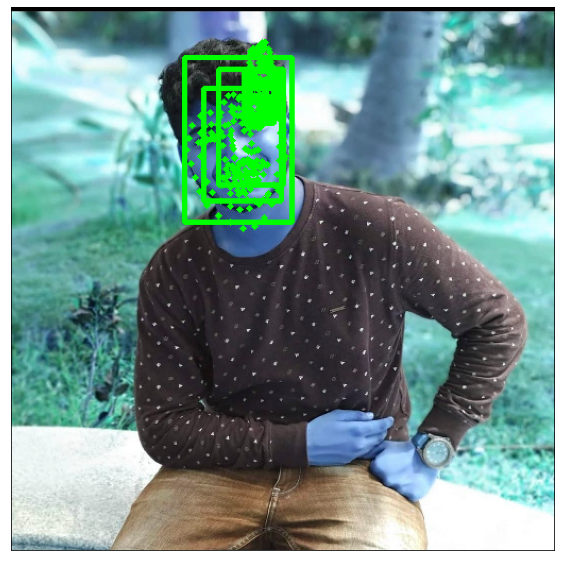

In [ ]:

shape = predictor(imgcv, rects)
shape = face_utils.shape_to_np(shape)
(x, y, w, h) = face_utils.rect_to_bb(rects)
cv2.rectangle(imgcv, (x, y), (x + w, y + h), (0, 255, 0), 3)

for (x, y) in shape:
  cv2.circle(imgcv, (x, y), 1, (0, 255, 0), 3)

plt.figure(figsize=(10,10))
plt.imshow(imgcv)
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
shape = predictor(image, rects)
shape = face_utils.shape_to_np(shape)    
(x, y, w, h) = face_utils.rect_to_bb(rect)
cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 3)

for (x, y) in shape:
  cv2.circle(image, (x, y), 1, (0, 255, 0), 3)

plt.figure(figsize=(10,10))
plt.imshow(image)
plt.xticks([])
plt.yticks([])
plt.show()

TypeError: ignored

In [ ]:
shape = predictor(imgcv,rects)

TypeError: ignored

In [ ]:
rect1=Rect( 0,  0, 10, 10)

NameError: ignored

In [ ]:
from Rectangle import Rectangle

ModuleNotFoundError: ignored

In [ ]:
rect = int(input())

2


In [ ]:
rect.shape

AttributeError: ignored